In [27]:
# import required libraries
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.layers import Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
#Creating a dataframe(name=df_audio) with two columns(path, label).   
#Eg: 0_jackson_0 --> 0 (label)
#0_jackson_43 --> 0 (label)
all_files = os.listdir('new')
df_audio = pd.DataFrame()
df_audio['path'] = ['new/' + ele for ele in all_files]
df_audio['target'] = [ele.split(' ')[0] for ele in all_files]

In [3]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    581 non-null    object
 1   target  581 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


In [4]:
# print few rows
df_audio.head()

,path,target
0,new/bulldozer Bulldoze zh-cn.mp3,bulldozer
1,new/bulldozer Bulldoze zh-tw.mp3,bulldozer
2,new/bulldozer Bulldozer af.mp3,bulldozer
3,new/bulldozer Bulldozer ar.mp3,bulldozer
4,new/bulldozer Bulldozer bg.mp3,bulldozer


In [5]:
# check uniques
df_audio.nunique()

path      581
target      5
dtype: int64

In [6]:
# check unique values in target column
df_audio['target'].value_counts()

bulldozer     118
excavators    116
JCB           116
roller        116
crane         115
Name: target, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

le.fit(df_audio['target'])

# Transform the 'target' column using the fitted LabelEncoder
df_audio['label'] = le.transform(df_audio['target'])


In [8]:
# encoded values
df_audio['label'].value_counts()

1    118
3    116
0    116
4    116
2    115
Name: label, dtype: int64

In [9]:
#shuffling the dataframe
df_audio = shuffle(df_audio, random_state=33)

### Preprocessing

All files are in the "mp3" format. We will read those raw data files using the librosa library</pre>

In [10]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This will return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(y = samples, sr = sample_rate)
        return [samples, duration]
    else:
        return samples

In [11]:
samples, durations = [],[]


for ele in df_audio['path'].values:
    try:
        sample, duration = load_wav(str(ele))
        samples.append(samples)
        durations.append(duration)
    except:
        print(ele)

processed = pd.DataFrame({'raw_data' : samples, 'duration' : durations})


In [12]:
processed.shape

(581, 2)

### Identifying optimal padding length

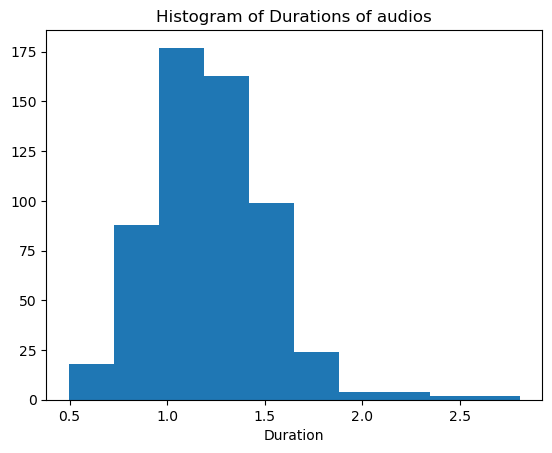

In [13]:
#plotting the histogram of the duration for trian
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of Durations of audios')
plt.show()

In [14]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,11,1):
    print(f"{i*10}th percentile is {np.percentile(processed.duration.values, i*10)}")

0th percentile is 0.4963265306122449
10th percentile is 0.8640362811791383
20th percentile is 0.96
30th percentile is 1.0320181405895692
40th percentile is 1.1280272108843536
50th percentile is 1.2
60th percentile is 1.2960090702947846
70th percentile is 1.3680272108843536
80th percentile is 1.4640362811791383
90th percentile is 1.56
100th percentile is 2.8080272108843536


In [15]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(0,11,1):
    print(f"{i+90}th percentile is {np.percentile(processed.duration.values, i+90)}")

90th percentile is 1.56
91th percentile is 1.5840362811791384
92th percentile is 1.5840362811791384
93th percentile is 1.6080272108843536
94th percentile is 1.6560090702947845
95th percentile is 1.68
96th percentile is 1.7424217687074808
97th percentile is 1.8
98th percentile is 1.8816145124716548
99th percentile is 2.1648072562358287
100th percentile is 2.8080272108843536


<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec.

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 2*22050 = 45000

Padding with Zero if length of sequence is less than 17640 else truncating the number. 

Also creating a masking vector for train and test. 

Masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type will be bool.
</pre>

## Generate Raw audio waveforms with data augmentation
<pre>
We have small dataset, thus we will perform augmentation on audios to improve the model performance. 
There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [18]:
## generating augmented data. 
def generate_augmented_data(file_path):
    augmented_data = []
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            time_stretch_data = librosa.effects.time_stretch(samples, rate=time_value)
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_audio.path, df_audio.label, stratify = df_audio.label, 
                                                    test_size = 0.2, random_state = 32321)

In [20]:
# generate augmented data
train_aug_data = []
train_labels = []

for path, label in zip(X_train.values, y_train.values):
    aug_data = generate_augmented_data(path)
    n_augmented = len(aug_data)
    train_aug_data.extend(aug_data)
    train_labels.extend([str(label)]*n_augmented)

X_train_processed = pd.DataFrame({'raw_data' : train_aug_data, 'label' : train_labels})

test_data = []
for path in X_test.values:
    test_data.append(load_wav(path, get_duration = False))

X_test_processed = pd.DataFrame({'raw_data' : test_data, 'label' : y_test.values})

In [21]:
# check
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   raw_data  4176 non-null   object
 1   label     4176 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [22]:
# print few rows
X_train_processed.head()

,raw_data,label
0,"[4.7327993e-07, 5.1230535e-07, 4.6442165e-07, ...",1
1,"[-2.0015218e-09, -3.8409333e-09, -3.1627836e-0...",1
2,"[1.0629081e-08, 1.0777184e-08, 1.0950133e-08, ...",1
3,"[-2.3022065e-07, -2.5660603e-07, -2.2576822e-0...",1
4,"[-3.4089363e-12, -2.714116e-12, -3.5769e-12, 2...",1


In [23]:
#padding the sequences
X_train_pad_seq = pad_sequences(X_train_processed.raw_data, maxlen = 45000,
                                dtype = 'float32', padding = 'post', 
                                truncating = 'post')
X_test_pad_seq = pad_sequences(X_test_processed.raw_data, maxlen = 45000, 
                               dtype = 'float32', padding = 'post', 
                               truncating = 'post')

y_train = X_train_processed.label.values.astype('int')
y_test = X_test_processed.label.values.astype('int')

X_train_mask = X_train_pad_seq != 0
X_test_mask = X_test_pad_seq != 0

## Using Spectrogram data with data augmentation
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. 
</pre>

In [24]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [25]:
##use convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad_seq.
## save those all in the X_train_spectrogram and X_test_spectrogram ( These two arrays must be numpy arrays)
X_train_spectrogram = []
for ele in X_train_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_train_spectrogram.append(logmel)
X_train_spectrogram = np.array(X_train_spectrogram)

X_test_spectrogram = []
for ele in X_test_pad_seq:
    logmel = convert_to_spectrogram(ele)
    X_test_spectrogram.append(logmel)
X_test_spectrogram = np.array(X_test_spectrogram)

## Model definition and training

### Custom Callbacks

In [ ]:
class F1ScoreCB(tf.keras.callbacks.Callback):
    def __init__(self, train_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.history = {}
        self.history['val_f1_score'] = []
  
    def on_epoch_end(self, epochs, logs = {}):
        train_preds = np.argmax(self.model.predict(self.train_data[0]), axis = -1)
        train_f1_score = f1_score(self.train_data[1], train_preds, average='micro')
        train_f1_score = np.round(train_f1_score, 4)

        test_preds = np.argmax(self.model.predict(self.test_data[0]), axis = -1)
        test_f1_score = f1_score(self.test_data[1], test_preds, average='micro')
        test_f1_score = np.round(test_f1_score, 4)
        self.history['val_f1_score'].append(test_f1_score)

        print(f" - f1_score: {train_f1_score} - val_f1_score: {test_f1_score}")

        writer1 = tf.summary.create_file_writer(logdir + '/train_f1_score')
        writer2 = tf.summary.create_file_writer(logdir + '/validation_f1_score')
        
        #writing to tensoboard
        with writer1.as_default():
            tf.summary.scalar('F1_Score', train_f1_score, step=epochs)
        writer1.flush()

        with writer2.as_default():
            tf.summary.scalar('F1_Score', test_f1_score, step=epochs)
        writer2.flush()

In [31]:
# define model architecture
tf.keras.backend.clear_session()
inp = Input(shape=(64, 88,))
x = LSTM(512, return_sequences=True)(inp)
x = Dropout(0.2)(x)
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = tf.math.reduce_mean(x, axis=-1)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.2)(x)
out = Dense(6, activation='softmax', kernel_initializer='glorot_normal')(x)

model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 88)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 512)           1230848   
                                                                 
 dropout (Dropout)           (None, 64, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64, 256)           787456    
                                                                 
 dropout_1 (Dropout)         (None, 64, 256)           0         
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                             

In [29]:
#log training
!rm -rf ./logs/
import datetime

logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

%tensorboard --logdir $logdir

'rm' is not recognized as an internal or external command,
operable program or batch file.


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [32]:
# compile and train model
model.compile(optimizer = tf.keras.optimizers.Adam(0.0005), loss = 'sparse_categorical_crossentropy')
cb = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True),
      F1ScoreCB((X_train_spectrogram, y_train), (X_test_spectrogram, y_test)),
      tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.005, patience = 4)]

model.fit(X_train_spectrogram, y_train, validation_data = (X_test_spectrogram, y_test),
           batch_size = 64, epochs = 15, callbacks = cb)

Epoch 1/15
4/4 [==============================] - 4s 1s/step
 - f1_score: 0.7004 - val_f1_score: 0.735
66/66 [==============================] - 501s 7s/step - loss: 1.2602 - val_loss: 0.8268
Epoch 2/15
4/4 [==============================] - 4s 679ms/step
 - f1_score: 0.8448 - val_f1_score: 0.8291
66/66 [==============================] - 471s 7s/step - loss: 0.7106 - val_loss: 0.5219
Epoch 3/15
4/4 [==============================] - 4s 680ms/step
 - f1_score: 0.8429 - val_f1_score: 0.8034
66/66 [==============================] - 476s 7s/step - loss: 0.5157 - val_loss: 0.4904
Epoch 4/15
4/4 [==============================] - 4s 786ms/step
 - f1_score: 0.8269 - val_f1_score: 0.812
66/66 [==============================] - 481s 7s/step - loss: 0.4675 - val_loss: 0.6056
Epoch 5/15
4/4 [==============================] - 4s 1s/step
 - f1_score: 0.8805 - val_f1_score: 0.906
66/66 [==============================] - 485s 7s/step - loss: 0.4902 - val_loss: 0.3617
Epoch 6/15
4/4 [==================

In [33]:
# Save the trained model to a file
model.save('model.h5')